# Part 3 : Mitigate Bias, Train another unbiased Model and Put in the Model Registry

<a id='aup-overview'></a>

## [Overview](./0-AutoClaimFraudDetection.ipynb)
* [Notebook 0 : Overview, Architecture and Data Exploration](./0-AutoClaimFraudDetection.ipynb)
* [Notebook 1: Data Prep, Process, Store Features](./1-data-prep-e2e.ipynb)
* [Notebook 2: Train, Check Bias, Tune, Record Lineage, and Register a Model](./2-lineage-train-assess-bias-tune-registry-e2e.ipynb)
* **[Notebook 3: Mitigate Bias, Train New Model, Store in Registry](./3-mitigate-bias-train-model2-registry-e2e.ipynb)**
  * **[Architecture](#train2)**
  * **[Develop a second model](#second-model)**
  * **[Analyze the Second Model for Bias](#analyze-second-model)**
  * **[View Results of Clarify Bias Detection Job](#view-second-clarify-job)**
  * **[Configure and Run Clarify Explainability Job](#explainability)**
  * **[Create Model Package for the Second Trained Model](#model-package)**
* [Notebook 4: Deploy Model, Run Predictions](./4-deploy-run-inference-e2e.ipynb)
* [Notebook 5 : Create and Run an End-to-End Pipeline to Deploy the Model](./5-pipeline-e2e.ipynb)

In this notebook, we will describe how to detect bias using Clarify, Mitigate it with SMOTE, train another model, put it in the Model Registry along with all the Lineage of the Artifacts created along the way: data, code and model metadata.

### Install required and/or update third-party libraries

In [ ]:
!python -m pip install -Uq pip
!python -m pip install -q awswrangler==2.2.0 imbalanced-learn==0.7.0 sagemaker==2.23.1 boto3==1.16.48

### Import libraries

In [2]:
import json
import time
import boto3
import sagemaker
import numpy as np
import pandas as pd
import awswrangler as wr
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost.estimator import XGBoost


from model_package_src.inference_specification import InferenceSpecification

%matplotlib inline

### Load stored variables
Run the cell below to load any prevously created variables. You should see a print-out of the existing variables. If you don't see anything you may need to create them again or it may be your first time running this notebook.

In [3]:
%store -r
%store

Stored variables and their in-db values:
bucket                              -> 'sagemaker-us-east-1-171928886260'
claims_fg_name                      -> 'fraud-detect-demo-claims'
claims_table                        -> 'fraud-detect-demo-claims-1618346734'
clarify_bias_job_1_name             -> 'Clarify-Bias-2021-04-13-21-59-54-456'
col_order                           -> ['fraud', 'customer_education', 'incident_type_bre
customers_fg_name                   -> 'fraud-detect-demo-customers'
customers_table                     -> 'fraud-detect-demo-customers-1618346737'
database_name                       -> 'sagemaker_featurestore'
hyperparameters                     -> {'max_depth': '3', 'eta': '0.2', 'objective': 'bin
model_1_name                        -> 'fraud-detect-demo-xgboost-pre-smote'
mpg_name                            -> 'fraud-detect-demo'
prefix                              -> 'fraud-detect-demo'
test_data_uri                       -> 's3://sagemaker-us-east-1-17192888626

**<font color='red'>Important</font>: You must have run the previous sequential notebooks to retrieve variables using the StoreMagic command.**

### Set region, boto3 and SageMaker SDK variables

In [4]:
#You can change this to a region of your choice
import sagemaker
region = sagemaker.Session().boto_region_name
print("Using AWS Region: {}".format(region))

Using AWS Region: us-east-1


In [5]:
boto3.setup_default_session(region_name=region)

boto_session = boto3.Session(region_name=region)

s3_client = boto3.client('s3', region_name=region)

sagemaker_boto_client = boto_session.client('sagemaker')

sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_boto_client)

sagemaker_role = sagemaker.get_execution_role()

account_id = boto3.client('sts').get_caller_identity()["Account"]

In [6]:
# variables used for parameterizing the notebook run
model_2_name = f'{prefix}-xgboost-post-smote'

train_data_upsampled_s3_path = f's3://{bucket}/{prefix}/data/train/upsampled/train.csv'
estimator_output_path = f's3://{bucket}/{prefix}/training_jobs'
bias_report_2_output_path = f's3://{bucket}/{prefix}/clarify-output/bias-2'
explainability_output_path = f's3://{bucket}/{prefix}/clarify-output/explainability'

train_instance_count = 1
train_instance_type = "ml.m5.large"

claify_instance_count = 1
clairfy_instance_type = 'ml.c5.large'

<a id ='train2'> </a>
## Architecture for this ML Lifecycle Stage : Train, Check Bias, Tune, Record Lineage, Register Model
[overview](#aup-overview)
___

![train-assess-tune-register](./images/e2e-2-pipeline-v3b.png)

<a id='second-model'></a>

## Develop a second model

[overview](#aup-overview)
___
In this second model, you will fix the gender imbalance in the dataset using SMOTE and train another model using XGBoost. This model will also be saved to our registry and eventually approved for deployment.

In [7]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

<a id='smote'></a>
### Resolve class imbalance using SMOTE

To handle the imbalance, we can over-sample (i.e. upsample) the minority class using [SMOTE (Synthetic Minority Over-sampling Technique)](https://arxiv.org/pdf/1106.1813.pdf). After installing the imbalanced-learn module, if you receive an ImportError when importing SMOTE, then try restarting the kernel. 

#### Gender balance before SMOTE

In [8]:
gender = train['customer_gender_female']
gender.value_counts()

0    2806
1    1194
Name: customer_gender_female, dtype: int64

#### Gender balance after SMOTE

In [9]:
sm = SMOTE(random_state=42)
train_data_upsampled, gender_res = sm.fit_resample(train, gender)
train_data_upsampled['customer_gender_female'].value_counts()

1    2806
0    2806
Name: customer_gender_female, dtype: int64

### Train new model


In [10]:
train_data_upsampled.to_csv('data/upsampled_train.csv', index=False)
s3_client.upload_file(Filename='data/upsampled_train.csv', Bucket=bucket, Key=f'{prefix}/data/train/upsampled/train.csv')

### Spot training
Managed Spot Training uses Amazon EC2 Spot instance to run training jobs instead of on-demand instances. You can specify which training jobs use spot instances and a stopping condition that specifies how long Amazon SageMaker waits for a job to run using Amazon EC2 Spot instances.

This time in the pipeline, we will perform XGBoost training using Spot Instances.

In [11]:
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")

use_spot_instances = True
max_run = 3600
max_wait = 7200 if use_spot_instances else None
checkpoint_s3_uri = (f's3://{bucket}/{prefix}/checkpoints/training_job_2_name' if use_spot_instances
                      else None)
print("Checkpoint path:", checkpoint_s3_uri)

xgb_estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container,
                                              output_path = estimator_output_path,
                                              code_location = estimator_output_path,
                                              hyperparameters = hyperparameters,
                                              role = sagemaker_role,
                                              instance_count = train_instance_count,
                                              instance_type = train_instance_type,
                                              disable_profiler=True,
                                              debugger_hook_config=False,
                                              framework_version = "1.0-1",
                                              use_spot_instances=use_spot_instances,
                                              max_run=max_run,
                                              max_wait=max_wait,
                                              checkpoint_s3_uri=checkpoint_s3_uri)

Checkpoint path: s3://sagemaker-us-east-1-171928886260/fraud-detect-demo/checkpoints/training_job_2_name


In [13]:
train_input = TrainingInput(train_data_upsampled_s3_path, content_type='csv')

xgb_estimator.fit(inputs = {'train': train_input})
training_job_2_name = xgb_estimator.latest_training_job.job_name

2021-04-14 03:36:12 Starting - Starting the training job...
2021-04-14 03:36:14 Starting - Launching requested ML instances.........
2021-04-14 03:37:45 Starting - Preparing the instances for training......
2021-04-14 03:38:58 Downloading - Downloading input data...
2021-04-14 03:39:24 Training - Downloading the training image...
2021-04-14 03:40:08 Training - Training image download completed. Training in progress..[2021-04-14 03:40:10.533 ip-10-2-104-32.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INF

In [16]:
if 'training_job_2_name' not in locals():
    
    train_input = TrainingInput(train_data_upsampled_s3_path, content_type='csv')

    xgb_estimator.fit(inputs = {'train': train_input})
    training_job_2_name = xgb_estimator.latest_training_job.job_name
    %store training_job_2_name
    
else:
    
    print(f'Using previous training job: {training_job_2_name}')

Using previous training job: sagemaker-xgboost-2021-04-14-03-36-12-033


### Register artifacts

In [14]:
training_job_2_info = sagemaker_boto_client.describe_training_job(TrainingJobName=training_job_2_name)

#### Code artifact

In [18]:
# return any existing artifact which match the our training job's code arn
code_s3_uri = training_job_2_info['AlgorithmSpecification']['TrainingImage']

list_response = list(sagemaker.lineage.artifact.Artifact.list(
    source_uri=code_s3_uri,
    sagemaker_session=sagemaker_session))

# use existing arifact if it's already been created, otherwise create a new artifact
if list_response:
    code_artifact = list_response[0]
    print(f'Using existing artifact: {code_artifact.artifact_arn}')
else:
    code_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name='TrainingScript',
        source_uri=code_s3_uri,
        artifact_type='Code',
        sagemaker_session=sagemaker_session)
    print(f'Create artifact {code_artifact.artifact_arn}: SUCCESSFUL')

Using existing artifact: arn:aws:sagemaker:us-east-1:171928886260:artifact/a810e305515d499301e6be5c269972f7


#### Training data artifact

In [19]:
training_data_s3_uri = training_job_2_info['InputDataConfig'][0]['DataSource']['S3DataSource']['S3Uri']

list_response = list(sagemaker.lineage.artifact.Artifact.list(
    source_uri=training_data_s3_uri,
    sagemaker_session=sagemaker_session))

if list_response:
    training_data_artifact = list_response[0]
    print(f'Using existing artifact: {training_data_artifact.artifact_arn}')
else:
    training_data_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name='TrainingData',
        source_uri=training_data_s3_uri,
        artifact_type='Dataset',
        sagemaker_session=sagemaker_session)
    print(f'Create artifact {training_data_artifact.artifact_arn}: SUCCESSFUL')

Using existing artifact: arn:aws:sagemaker:us-east-1:171928886260:artifact/63a02d2f7313e834c3e82b3db31385f6


#### Model artifact

In [20]:
trained_model_s3_uri = training_job_2_info['ModelArtifacts']['S3ModelArtifacts']

list_response = list(sagemaker.lineage.artifact.Artifact.list(
    source_uri=trained_model_s3_uri,
    sagemaker_session=sagemaker_session))

if list_response:
    model_artifact = list_response[0]
    print(f'Using existing artifact: {model_artifact.artifact_arn}')
else:
    model_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name='TrainedModel',
        source_uri=trained_model_s3_uri,
        artifact_type='Model',
        sagemaker_session=sagemaker_session)
    print(f'Create artifact {model_artifact.artifact_arn}: SUCCESSFUL')

Using existing artifact: arn:aws:sagemaker:us-east-1:171928886260:artifact/65a8d587542948b35fd8750c2ef830e3


### Set artifact associations

In [21]:
trial_component = sagemaker_boto_client.describe_trial_component(TrialComponentName=training_job_2_name+'-aws-training-job')
trial_component_arn = trial_component['TrialComponentArn']

#### Input artifacts

In [22]:
input_artifacts = [code_artifact, training_data_artifact]

for a in input_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type='ContributedTo',
            sagemaker_session=sagemaker_session)
        print(f"Associate {trial_component_arn} and {a.artifact_arn}: SUCCEESFUL\n")
    except:
        print(f"Association already exists between {trial_component_arn} and {a.artifact_arn}.\n")

Associate arn:aws:sagemaker:us-east-1:171928886260:experiment-trial-component/sagemaker-xgboost-2021-04-14-03-36-12-033-aws-training-job and arn:aws:sagemaker:us-east-1:171928886260:artifact/a810e305515d499301e6be5c269972f7: SUCCEESFUL

Association already exists between arn:aws:sagemaker:us-east-1:171928886260:experiment-trial-component/sagemaker-xgboost-2021-04-14-03-36-12-033-aws-training-job and arn:aws:sagemaker:us-east-1:171928886260:artifact/63a02d2f7313e834c3e82b3db31385f6.



#### Output artifacts

In [23]:
output_artifacts = [model_artifact]

for artifact_arn in output_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type='Produced',
            sagemaker_session=sagemaker_session)
        print(f"Associate {trial_component_arn} and {a.artifact_arn}: SUCCEESFUL\n")
    except:
        print(f"Association already exists between {trial_component_arn} and {a.artifact_arn}.\n")

Association already exists between arn:aws:sagemaker:us-east-1:171928886260:experiment-trial-component/sagemaker-xgboost-2021-04-14-03-36-12-033-aws-training-job and arn:aws:sagemaker:us-east-1:171928886260:artifact/63a02d2f7313e834c3e82b3db31385f6.



<pre>

</pre>

<a id ='analyze-second-model'></a>
## Analyze the second model for bias and explainability

[overview](#aup-overview)
___
Amazon SageMaker Clarify provides tools to help explain how machine learning (ML) models make predictions. These tools can help ML modelers and developers and other internal stakeholders understand model characteristics as a whole prior to deployment and to debug predictions provided by the model after it's deployed. Transparency about how ML models arrive at their predictions is also critical to consumers and regulators who need to trust the model predictions if they are going to accept the decisions based on them. SageMaker Clarify uses a model-agnostic feature attribution approach, which you can used to understand why a model made a prediction after training and to provide per-instance explanation during inference. The implementation includes a scalable and efficient implementation of SHAP ([see paper](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)), based on the concept of a Shapley value from the field of cooperative game theory that assigns each feature an importance value for a particular prediction. 

### Create model from estimator

In [24]:
model_matches = sagemaker_boto_client.list_models(NameContains=model_2_name)['Models']

if not model_matches:
    
    model_2 = sagemaker_session.create_model_from_job(
        name=model_2_name,
        training_job_name=training_job_2_info['TrainingJobName'],
        role=sagemaker_role,
        image_uri=training_job_2_info['AlgorithmSpecification']['TrainingImage'])
    %store model_2_name
    
else:
    
    print(f"Model {model_2_name} already exists.")

Stored 'model_2_name' (str)


<a id='bias-v1'></a>
### Check for data set bias and model bias

With SageMaker, we can check for pre-training and post-training bias. Pre-training metrics show pre-existing bias in that data, while post-training metrics show bias in the predictions from the model. Using the SageMaker SDK, we can specify which groups we want to check bias across and which metrics we'd like to show. 

To run the full Clarify job, you must un-comment the code in the cell below. Running the job will take ~15 minutes. If you wish to save time, you can view the results in the next cell after which loads a pre-generated output if no bias job was run.

In [26]:
clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=sagemaker_role,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    sagemaker_session=sagemaker_session)

bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_upsampled_s3_path,
    s3_output_path=bias_report_2_output_path,
    label='fraud',
    headers=train.columns.to_list(),
    dataset_type='text/csv')

model_config = sagemaker.clarify.ModelConfig(
    model_name=model_2_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type='text/csv')

predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name='customer_gender_female',
    facet_values_or_threshold=[1])

# # un-comment the code below to run the whole job

# if 'clarify_bias_job_2_name' not in locals():

#     clarify_processor.run_bias(
#         data_config=bias_data_config,
#         bias_config=bias_config,
#         model_config=model_config,
#         model_predicted_label_config=predictions_config,
#         pre_training_methods='all',
#         post_training_methods='all')

#     clarify_bias_job_2_name = clarify_processor.latest_job.name
#     %store clarify_bias_job_2_name

# else:
#     print(f'Clarify job {clarify_bias_job_2_name} has already run successfully.')


Job Name:  Clarify-Bias-2021-04-14-03-42-35-721
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-171928886260/fraud-detect-demo/data/train/upsampled/train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-171928886260/Clarify-Bias-2021-04-14-03-42-35-721/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-171928886260/fraud-detect-demo/clarify-output/bias-2', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...

<a id ='view-second-clarify-job'></a>
## View results of Clarify job
[overview](#aup-overview)
___

Running Clarify on your dataset or model can take ~15 minutes. If you don't have time to run the job, you can view the pre-generated results included with this demo. Otherwise, you can run the job by un-commenting the code in the cell above.

In [27]:
if 'clarify_bias_job_2_name' in locals():
    s3_client.download_file(
        Bucket   = bucket, 
        Key      = f'{prefix}/clarify-output/bias-2/analysis.json', 
        Filename = 'clarify_output/bias_2/analysis.json'
    )
    print(f'Downloaded analysis from previous Clarify job: {clarify_bias_job_2_name}\n')
else:
    print(f'Loading pre-generated analysis file...\n')

with open('clarify_output/bias_1/analysis.json', 'r') as f:
        bias_analysis = json.load(f)

results = bias_analysis['pre_training_bias_metrics']['facets']['customer_gender_female'][0]['metrics'][1]
print(json.dumps(results, indent=4))

with open('clarify_output/bias_2/analysis.json', 'r') as f:
        bias_analysis = json.load(f)

results = bias_analysis['pre_training_bias_metrics']['facets']['customer_gender_female'][0]['metrics'][1]
print(json.dumps(results, indent=4))

Downloaded analysis from previous Clarify job: Clarify-Bias-2021-04-14-03-42-35-721

{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.398
}
{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.0
}


<a id ='explainability' ></a>
## Configure and run explainability job
[overview](#aup-overview)
___
To run the full Clarify job, you must un-comment the code in the cell below. Running the job will take ~15 minutes. If you wish to save time, you can view the results in the next cell after which loads a pre-generated output if no explainability job was run.

In [35]:
model_config = sagemaker.clarify.ModelConfig(
    model_name=model_2_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type='text/csv')

shap_config = sagemaker.clarify.SHAPConfig(
    baseline=[train.median().values[1:].tolist()],
    num_samples=100,
    agg_method='mean_abs')

explainability_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_upsampled_s3_path,
    s3_output_path=explainability_output_path,
    label='fraud',
    headers=train.columns.to_list(),
    dataset_type='text/csv')

# # un-comment the code below to run the whole job

# if 'clarify_expl_job_name' not in locals():

#     clarify_processor.run_explainability(
#         data_config=explainability_data_config,
#         model_config=model_config,
#         explainability_config=shap_config)
    
#     clarify_expl_job_name = clarify_processor.latest_job.name
#     %store clarify_expl_job_name
    
# else:
#     print(f'Clarify job {clarify_expl_job_name} has already run successfully.')


Job Name:  Clarify-Explainability-2021-04-14-04-00-30-082
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-171928886260/fraud-detect-demo/data/train/upsampled/train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-171928886260/Clarify-Explainability-2021-04-14-04-00-30-082/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-171928886260/fraud-detect-demo/clarify-output/explainability', 'LocalPath': '/opt/ml/processing/output', 'S3Up

### View Clarify explainability results (shortcut)
Running Clarify on your dataset or model can take ~15 minutes. If you don't have time to run the job, you can view the pre-generated results included with this demo. Otherwise, you can run the job by un-commenting the code in the cell above.

Downloaded analysis from previous Clarify job: Clarify-Explainability-2021-04-14-04-00-30-082



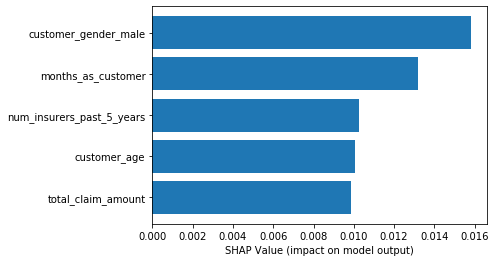

In [36]:
if 'clarify_expl_job_name' in locals():
    s3_client.download_file(
        Bucket   = bucket, 
        Key      = f'{prefix}/clarify-output/explainability/analysis.json', 
        Filename = 'clarify_output/explainability/analysis.json'
    )
    print(f'Downloaded analysis from previous Clarify job: {clarify_expl_job_name}\n')
else:
    print(f'Loading pre-generated analysis file...\n')

with open('clarify_output/explainability/analysis.json', 'r') as f:
        analysis_result = json.load(f)
        
shap_values = pd.DataFrame(analysis_result['explanations']['kernel_shap']["label0"])
importances = shap_values['global_shap_values'].sort_values(ascending=False)
fig, ax = plt.subplots()
n = 5
y_pos = np.arange(n)
importance_scores = importances.values[:n]
y_label = importances.index[:n]
ax.barh(y_pos, importance_scores, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
ax.invert_yaxis()  
ax.set_xlabel('SHAP Value (impact on model output)');

To see the autogenerated SageMaker Clarify report, run the following code and use the output link to open the report.

In [37]:
from IPython.display import FileLink, FileLinks
display("Click link below to view the SageMaker Clarify report", FileLink("clarify_output/report.pdf"))

'Click link below to view the SageMaker Clarify report'

/root/amazon-sagemaker-examples/end_to_end/clarify_output/report.pdf

### What is SHAP?
SHAP is the method used for calculating explanations in this solution.
Unlike other feature attribution methods, such as single feature
permutation, SHAP tries to disentangle the effect of a single feature by
looking at all possible combinations of features.

[SHAP](https://github.com/slundberg/shap) (Lundberg et al. 2017) stands
for SHapley Additive exPlanations. 'Shapley' relates to a game theoretic
concept called [Shapley
values](https://en.wikipedia.org/wiki/Shapley_value) that is used to
create the explanations. A Shapley value describes the marginal
contribution of each 'player' when considering all possible 'coalitions'.
Using this in a machine learning context, a Shapley value  describes the
marginal contribution of each feature when considering all possible sets
of features. 'Additive' relates to the fact that these Shapley values can
be summed together to give the final model prediction.

As an example, we might start off with a baseline credit default risk of
10%. Given a set of features, we can calculate the Shapley value for each
feature. Summing together all the Shapley values, we might obtain a
cumulative value of +30%. Given the same set of features, we therefore
expect our model to return a credit default risk of 40% (i.e. 10% + 30%).

<a id='model-package' ></a>
## Create Model Package for the Second Trained Model
[overview](#aup-overview)
___

#### Create and upload second model metrics report

In [29]:
model_metrics_report = {'classification_metrics': {}}
for metric in training_job_2_info['FinalMetricDataList']:
    stat = {metric['MetricName']: {'value': metric['Value']}}
    model_metrics_report['classification_metrics'].update(stat)
    
with open('training_metrics.json', 'w') as f:
    json.dump(model_metrics_report, f)
    
metrics_s3_key = f"{prefix}/training_jobs/{training_job_2_info['TrainingJobName']}/training_metrics.json"
s3_client.upload_file(Filename='training_metrics.json', Bucket=bucket, Key=metrics_s3_key)

#### Define inference specification

In [30]:
mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_job_2_info['AlgorithmSpecification']['TrainingImage'],
    supports_gpu=False,
    supported_content_types=['text/csv'],
    supported_mime_types=['text/csv'])

mp_inference_spec['InferenceSpecification']['Containers'][0]['ModelDataUrl'] = training_job_2_info['ModelArtifacts']['S3ModelArtifacts']

#### Define model metrics

In [31]:
model_metrics = {
    'ModelQuality': {
        'Statistics': {
            'ContentType': 'application/json',
            'S3Uri': f's3://{bucket}/{prefix}/{metrics_s3_key}'
        }
    },
    'Bias': {
        'Report': {
            'ContentType': 'application/json',
            'S3Uri': f'{explainability_output_path}/analysis.json'
        }
    }
}

#### Register second model package to Model Package Group

In [32]:
mp_input_dict = {
    'ModelPackageGroupName': mpg_name,
    'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud with SMOTE.',
    'ModelApprovalStatus': 'PendingManualApproval',
    'ModelMetrics': model_metrics
}

mp_input_dict.update(mp_inference_spec)
mp2_response = sagemaker_boto_client.create_model_package(**mp_input_dict)
mp2_arn = mp2_response['ModelPackageArn']
%store mp2_arn

Stored 'mp2_arn' (str)


#### Check status of model package creation

In [33]:
mp_info = sagemaker_boto_client.describe_model_package(ModelPackageName=mp2_response['ModelPackageArn'])
mp_status = mp_info['ModelPackageStatus']

while mp_status not in ['Completed', 'Failed']:
    time.sleep(5)
    mp_info = sagemaker_boto_client.describe_model_package(ModelPackageName=mp2_response['ModelPackageArn'])
    mp_status = mp_info['ModelPackageStatus']
    print(f'model package status: {mp_status}')
print(f'model package status: {mp_status}')

model package status: Completed


### View both models in the registry

In [34]:
sagemaker_boto_client.list_model_packages(ModelPackageGroupName=mpg_name)['ModelPackageSummaryList']

[{'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 3,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:171928886260:model-package/fraud-detect-demo/3',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud with SMOTE.',
  'CreationTime': datetime.datetime(2021, 4, 14, 4, 0, 20, 629000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'},
 {'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 2,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:171928886260:model-package/fraud-detect-demo/2',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud.',
  'CreationTime': datetime.datetime(2021, 4, 14, 3, 59, 51, 159000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'},
 {'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 1,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:17192888

___

### Next Notebook: [Deploy Model, Run Predictions](./4-deploy-run-inference-e2e.ipynb)